In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.io import loadmat
import scipy.optimize as opt
%matplotlib inline

In [2]:
mat = loadmat("ex4data1.mat")
input_layer_size = 400
num_labels = 10
X = mat['X']
y = mat['y']
m = X.shape[0]
n = X.shape[1]
# For creating identity matrix
# Because index 10
y = y -1

In [3]:
y

array([[9],
       [9],
       [9],
       ...,
       [8],
       [8],
       [8]], dtype=uint8)

In [4]:
# Our Network consists of 20 by 20 - 400 input layer units, 25 hidden layer units
# and 10 output layer classes

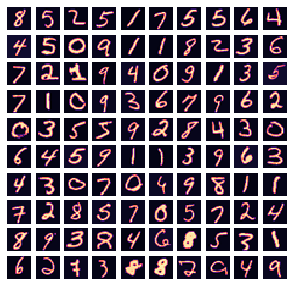

In [5]:
# Create 10 by 10 100 subplots
# use imshow to convert b&w intensity to images, reshape because column major
fig, axes = plt.subplots(10, 10, figsize = (5,5))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(X[np.random.randint(0,5000),:].reshape(20,20, order = "F"), cmap= "magma")
        axes[i,j].axis("off")

In [6]:
weights = loadmat("ex4weights.mat")
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
l = 0
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
# print(Theta1.shape, Theta2.shape)
# (25, 401) (10, 26)

In [7]:
nn_params = np.hstack((np.ravel(Theta1),np.ravel(Theta2)))[:,np.newaxis]
# print(nn_params.shape) (10285, 1)

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [9]:
def nnCostFunction(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l):
    # Forward Propogation
    Theta1 = initial_nn_params[:(hidden_layer_size * (input_layer_size + 1))].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = initial_nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((num_labels, hidden_layer_size + 1))
    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    #Input Layer (5000 by 401)(a1)
    a1 = np.hstack((np.ones((m,1)), X))
    # Hidden Layer  5000 by 25(a2)
    z2 = a1 @ Theta1.T
    a2 = sigmoid(z2)
    # Output Layer 5000 by 10(a3)
    a2 = np.hstack((np.ones((m,1)), a2))
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)
    
    # Create 5000 by 10 y matrix
    e = np.identity(num_labels)
    ymat = e[y,:][:,0,:]
        
    todoublesum = (ymat * np.log(a3)) + ((1 - ymat) * np.log(1 - a3))
    J = (-1/m) * sum(sum(todoublesum))
    # Regularization for each layer of theta
    reg = sum(sum(Theta1[:,1:] ** 2)) + sum(sum(Theta2[:,1:] ** 2))
    J = J + (l/(2 * m) * reg)
    
    # BackPropogation
    # d is derivative of J with respect to z
    # Bias doesnt connect back while backprop
    # Dim (5000 by 10)
    d3 = a3 - ymat
    # Dim (5000 by 25)
    d2 = (d3 @ Theta2[:,1:]) * SigmoidGradient(z2)
    
    # Delta - Accumulators just the partial derivative fof part
    # Dim 25 by 401
    Delta1 = d2.T @ a1
    # Dim 10 by 26
    Delta2 = d3.T @ a2
    
    # Theta1_grad and Theta2_grad contains delta + reg
    
    Theta1_grad = Delta1/m
    Theta2_grad = Delta2/m
    
    # Set to zero cos of return grad dim
    Theta1[:,0] = 0
    Theta2[:,0] = 0
    
    Theta1_grad = Theta1_grad + (Theta1 * (l/m))
    Theta2_grad = Theta2_grad + (Theta2 * (l/m))
    
    grad = np.hstack((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))[:,np.newaxis]
    return J,grad

In [10]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = 0.12
    W = (np.random.rand(L_out, 1 + L_in) * (2 * epsilon_init)) - epsilon_init
    return W

In [11]:
def SigmoidGradient(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [12]:
# Cost Function without Regularization
l = 0
J,_ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l)
print(J)

0.2876291651613188


In [13]:
# Cost Function with Regularization
l = 1
J,_ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l)
print(J)

0.42052559982321974


In [14]:
def CheckGradient(X, y, unrolled_theta,lmbda):
    # Every theta has a grad
    epsilon = 0.0001
    elems = len(unrolled_theta)
    # Calculated grad from backprop
    _,backpropgrad = nnCostFunction(unrolled_theta,input_layer_size,hidden_layer_size,num_labels, X,y,lmbda)
    # Take random 10 elements
    for i in range(10):
        index = np.random.randint(elems)
        epsvec = np.zeros((elems,1))
        epsvec[index] = epsilon
        cost1,_ = nnCostFunction(unrolled_theta + epsvec, input_layer_size,hidden_layer_size,num_labels, X,y,lmbda)
        cost2,_ = nnCostFunction(unrolled_theta - epsvec, input_layer_size,hidden_layer_size,num_labels, X,y,lmbda)
        num_grad = (cost1 - cost2)/(2 * epsilon)
        print("Ele: {0}. Numerical Gradient = {1:.9f}. BackPropGrad ={2:.9f}".format(index,num_grad,backpropgrad.flatten()[index]))

In [15]:
# Gradient Check
CheckGradient(X, y, nn_params, 1)
# BackProp Looks Good!

Ele: 3660. Numerical Gradient = -0.000005954. BackPropGrad =-0.000005954
Ele: 3272. Numerical Gradient = -0.000001033. BackPropGrad =-0.000001033
Ele: 2165. Numerical Gradient = -0.000030566. BackPropGrad =-0.000030566
Ele: 6326. Numerical Gradient = -0.000810363. BackPropGrad =-0.000810363
Ele: 8548. Numerical Gradient = 0.000527821. BackPropGrad =0.000527821
Ele: 8085. Numerical Gradient = -0.000045985. BackPropGrad =-0.000045985
Ele: 1669. Numerical Gradient = 0.000001886. BackPropGrad =0.000001886
Ele: 4254. Numerical Gradient = -0.001963960. BackPropGrad =-0.001963960
Ele: 7647. Numerical Gradient = -0.000007424. BackPropGrad =-0.000007424
Ele: 684. Numerical Gradient = -0.000061428. BackPropGrad =-0.000061428


ALL Set Train Now

In [16]:
# Initialize to Random Weights for Training
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.hstack((np.ravel(initial_Theta1),np.ravel(initial_Theta2)))[:,np.newaxis]
Theta1 = initial_nn_params[:(hidden_layer_size * (input_layer_size + 1))].reshape((hidden_layer_size, input_layer_size + 1))
Theta2 = initial_nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((num_labels, hidden_layer_size + 1))

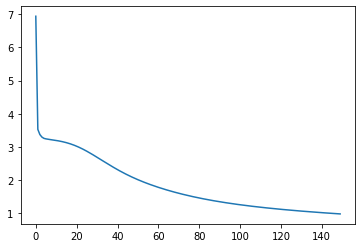

In [17]:
# Training
l = 0.7
num_iters = 150
J_history = []
alpha = 1
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.hstack((np.ravel(initial_Theta1),np.ravel(initial_Theta2)))[:,np.newaxis]
for i in range(num_iters):
    cost,grad = nnCostFunction(initial_nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l)
    initial_nn_params = initial_nn_params - (alpha * grad)
    J_history.append(cost)
plt.plot(J_history)

In [18]:
theta1_opt = initial_nn_params[:(hidden_layer_size * (input_layer_size + 1))].reshape((hidden_layer_size, input_layer_size + 1))
theta2_opt = initial_nn_params[(hidden_layer_size * (input_layer_size + 1)):].reshape((num_labels, hidden_layer_size + 1))
print(Theta1.shape,Theta2.shape)

(25, 401) (10, 26)


In [19]:
def predict(Theta1, Theta2, X, y):
    m = len(y)
    ones = np.ones((m,1))
    a1 = np.hstack((ones,X))
    a2 = sigmoid(a1 @ Theta1.T)
    a2 = np.hstack((ones,a2))
    h = sigmoid(a2 @ Theta2.T)
    return np.argmax(h,1)

In [20]:
# Accuracy
pred = predict(theta1_opt, theta2_opt, X, y)
np.mean(pred==y.flatten())* 100

88.42

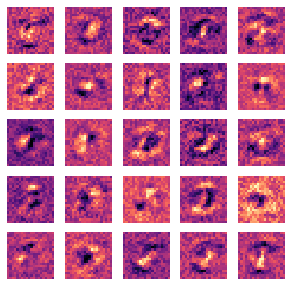

In [21]:
# Visualizing Theta1
d = 0
fig,axes = plt.subplots(5,5,figsize=(5,5))
for i in range(5):
    for j in range(5):
        axes[i,j].imshow(theta1_opt[d,1:].reshape(20,20,order = "F"), cmap = 'magma')
        axes[i,j].axis("off")
        d+=1